rootディレクトリに移動 

In [1]:
%cd ../..

E:\システムトレード入門\trade_system_git_workspace


# 強化学習で株取引　その１ 

今回は環境の作成もかねて，一つの銘柄の取引を強化学習で行う．予測とはアルゴリズムを分離するため，未来の株価も含めるように調整する．

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy.random import RandomState
import pandas as pd
from tqdm.notebook import tqdm
import collections

In [3]:
import gym
from gym import spaces, logger
from gym.utils import seeding

In [4]:
import datetime
from pytz import timezone

In [5]:
from pathlib import Path

In [6]:
import pfrl

In [7]:
from get_stock_price import StockDatabase

In [8]:
from utils import middle_sample_type_with_check, get_sec_from_freq, get_workdays_jp, get_previous_datetime, get_next_workday_jp
from utils import extract_workdays_intraday_jp_index, extract_workdays_intraday_jp

### データベース 

In [9]:
db_path = Path("E:/システムトレード入門/trade_system_git_workspace/db/stock_db") / Path("stock.db")
stock_db = StockDatabase(db_path)

In [10]:
stock_list = ["4755","9984","6701","7203","7267"]
stock_db.stock_in(stock_list)

array([ True,  True,  True,  True,  True])

In [11]:
stock_db.stock_timestamp(stock_list)

,min_datetime,max_datetime,column_name
0,2020-11-02 00:00:00+00:00,2021-03-16 05:59:00+00:00,4755
1,2020-11-02 00:00:00+00:00,2021-03-16 05:59:00+00:00,9984
2,2020-11-02 00:00:00+00:00,2021-03-16 05:59:00+00:00,6701
3,2020-11-02 00:00:00+00:00,2021-03-16 05:59:00+00:00,7203
4,2020-11-02 00:00:00+00:00,2021-03-16 05:59:00+00:00,7267


In [12]:
jst_timezone = timezone("Asia/Tokyo")
start_datetime = jst_timezone.localize(datetime.datetime(2020,11,1,0,0,0))
end_datetime = jst_timezone.localize(datetime.datetime(2020,12,1,0,0,0))

stock_df = stock_db.search_span(stock_names=["6502"], 
                                start_datetime=start_datetime,
                                end_datetime=end_datetime,
                                freq_str="T",
                                to_tokyo=True
                               )
stock_df

,Open_6502,High_6502,Low_6502,Close_6502,Volume_6502
timestamp,,,,,
2020-11-02 09:00:00+09:00,2607.0,2620.0,2606.0,2617.0,0.0
2020-11-02 09:01:00+09:00,2619.0,2627.0,2619.0,2627.0,4900.0
2020-11-02 09:02:00+09:00,2634.0,2636.0,2634.0,2634.0,30000.0
2020-11-02 09:03:00+09:00,2636.0,2642.0,2633.0,2636.0,35000.0
2020-11-02 09:04:00+09:00,2638.0,2640.0,2633.0,2638.0,10100.0
...,...,...,...,...,...
2020-11-30 23:55:00+09:00,NaN,NaN,NaN,NaN,NaN
2020-11-30 23:56:00+09:00,NaN,NaN,NaN,NaN,NaN
2020-11-30 23:57:00+09:00,NaN,NaN,NaN,NaN,NaN


### 環境クラス 

#### 前処理用のクラス 

In [13]:
class NormalizeState():
    def __init__(self, init_cash, init_cash_times=1, unit_const=1, price_const=1, replace=False):
        self.cash_devide_const = init_cash * init_cash_times
        self.unit_devide_const = unit_const
        self.price_devide_const = price_const
        
        self.replace = replace
        
    def __call__(self, state):
        if not self.replace:
            state = state.copy()

        # cash
        state[0] = state[0]/self.cash_devide_const
        # unit
        state[1] = state[1]/self.unit_devide_const
        # price
        state[2:] = state[2:]/self.price_devide_const

        return state

class NormalizeReward():
    def __init__(self, init_cash, init_cash_times=1):
        self.reward_devide_const = init_cash * init_cash_times
        
    def __call__(self, reward):
        reward = reward / self.reward_devide_const
        
        return reward

#### サンプリングのためのクラス

In [14]:
class WindowSampler():
    def __init__(self, stock_names, start_datetime, end_datetime, freq_str, end_include=False):
        """
        指定した範囲から，エピソード分利用可能なdatetimeをサンプリングするためのクラス
        """
        if isinstance(stock_names, str):  # 銘柄コードが一つの場合
            stock_names = [stock_names]
        self.stock_names = stock_names
        
        self.start_datetime = start_datetime
        self.end_datetime = end_datetime
        # タイムゾーンが同じかチェック
        if self.start_datetime.tzinfo != self.end_datetime.tzinfo:
            raise Exception("The timezone of start_datetime and end_datetime must be same")
        
        self.freq_str = middle_sample_type_with_check(freq_str)
                
        stock_name_datetime_array_list = []
        
        for stock_name in stock_names:
            # 指定した範囲内，周期のdatetimeのndarrayを取得
            if end_include:
                datetime_index = pd.date_range(start=self.start_datetime,
                                               end=self.end_datetime,
                                               freq=self.freq_str
                                              )
                
            else:
                datetime_index = pd.date_range(start=self.start_datetime,
                                               end=get_previous_datetime(self.end_datetime, freq_str=self.freq_str),
                                               freq=self.freq_str
                                              )

            datetime_index = extract_workdays_intraday_jp_index(datetime_index, return_as="index")
            
            stock_name_array = np.full(len(datetime_index), stock_name).astype(object)  # object同士でstackするため
            datetime_array = datetime_index.to_pydatetime()
            stock_name_datetime_array = np.stack([stock_name_array, datetime_array], axis=1)  # [銘柄コード, datetime]のndarray
            stock_name_datetime_array_list.append(stock_name_datetime_array)
            
    
        self.all_stockname_datetime_array = np.concatenate(stock_name_datetime_array_list, axis=0)
        
    def sample(self, seed=None, remove=False):
        if seed is not None and remove:
            raise Exception("If use seed, cannot remove")
            
        random_index = RandomState(seed).randint(0, len(self.all_stockname_datetime_array))
        #ランダムに取り出す
        stock_datetime = self.all_stockname_datetime_array[random_index]
        # 取り出したものを削除
        if remove:
            self.all_stockname_datetime_array = np.delete(self.all_stockname_datetime_array,random_index,axis=0)
        return stock_datetime

In [15]:
#jst_timezone = timezone("Asia/Tokyo")
#start_datetime = jst_timezone.localize(datetime.datetime(2020,11,1,0,0,0))
#end_datetime = jst_timezone.localize(datetime.datetime(2020,12,1,0,0,0))

start_datetime = datetime.datetime(2020,11,1,0,0,0)
end_datetime = datetime.datetime(2020,12,1,0,0,0)
#stock_names = "6502"
stock_names = ["6502","4755"]

window_sampler = WindowSampler(stock_names, start_datetime, end_datetime, freq_str="T", end_include=False)

In [16]:
window_sampler.sample(seed=133, remove=False)

array(['4755', datetime.datetime(2020, 11, 27, 10, 53)], dtype=object)

#### 環境クラス本体  

In [24]:
class OneStockEnv(gym.Env):
    """
    一つの銘柄の株式に関する環境
    """
    def __init__(self, 
                 stock_db,
                 stock_names,
                 start_datetime,
                 end_datetime,
                 freq_str,
                 episode_length,
                 state_time_list=[0],
                 use_ohlc="Close",
                 initial_cash=1.e6,  # 100万円
                 initial_unit=50,  # 初期単元数
                 use_view=False,
                 one_unit_stocks=100,
                 max_units_number=10,
                 low_limmit=1.e3,  # 1000円
                 interpolate=True,
                 sample_remove=False,
                 penalty_ratio=1.e-4,
                 penalty_init_cash_bound=0.1,
                 action_restriction = False
                ):
        """
        stock_db: StockDataBase
            値を読み込むデータベース．1エピソード分のデータをreset事に読み込む
        stock_names: str list
            利用するデータの銘柄，複数指定した場合はreset時にランダムで決定される
        start_datetime: datetime
            利用するデータの始端
        ed_datetime: datetime
            利用するデータの終端
        freq_str: str
            サンプリング周期
        episode_length: int
            1エピソードの状態の個数
        start_time_list: int list
            状態として利用する株価の現在からのインデックスのリスト．最初の値は現在(0)でなければならない
        use_ohlc: str, defalt: "Close"
            サンプリング周期における利用するデータの指定(Open, High, Low, Close)
        initial_cash: int, defalt: 1.e6
            種銭
        use_view: bool
            reset時にviewを使うかどうか．使う場合，若干高速になるがcloseをしなければならない
        one_unit_stocks: int
            単元数．通常は100だが，独自に定義できる
        max_units_number: int, default: 10
            売買時の単元のセット数の上限・下限．
        low_limmmit: int, defalt:1.e3
            資産額の下限値．この値を下回った場合，エピソードを終了する．
        interpolate: bool
            指定した期間内のデータ中にnanがあった場合，あるいはデータが取得できなかった場合に補間をするかどうか
        sample_remove: bool
            reset時に取得するデータで一度利用したデータを取り除くかどうか
        """
        
        # データベース
        self.stock_db = stock_db
        # ビューの作成
        self.use_view = use_view
        if self.use_view:
            self.stock_view = self.stock_db.create_view(stock_names, start_datetime=start_datetime, end_datetime=end_datetime)
        
        # 利用するohlcのいずれか
        if use_ohlc not in {"Open","High","Low","Close"}:
            raise Exception("use_ohlc must be in {'Open','High','Low','Close'}")
        self.use_ohlc = use_ohlc
        
        self.freq_str = middle_sample_type_with_check(freq_str)
        # 全datetimeデータを保持
        all_datetime_index = pd.date_range(start=start_datetime,
                                           end=get_previous_datetime(end_datetime, freq_str=self.freq_str),
                                           freq=self.freq_str,
                                          )
        
        self.all_datetime_index = extract_workdays_intraday_jp_index(all_datetime_index, return_as="index")
            
        self.episode_length = episode_length
        self.initial_cash = initial_cash
        self.initial_unit = initial_unit
        self.low_limmit = low_limmit
        self.interpolate = interpolate
        self.sample_remove = sample_remove
        self.seed_number = None
        self.penalty_ratio = penalty_ratio
        self.penalty_init_cash_bound = penalty_init_cash_bound
        self.action_restriction = action_restriction
        
        if state_time_list[0] != 0:
            raise Exception("The first value of state_time_list must be 0")
        
        self.state_time_list = state_time_list
        
        self.max_state_time = max(state_time_list)  # 利用する未来の状態の現在からのタイムステップ数
        last_start_datetime = self.all_datetime_index[-(self.max_state_time + self.episode_length)]  # エピソードの開始時刻の最後

        self.sampler = WindowSampler(stock_names,
                                     start_datetime=start_datetime,
                                     end_datetime=last_start_datetime,
                                     freq_str=self.freq_str,
                                     end_include=True,  # 最後も含む
                                    )
        # 状態空間と行動空間の定義
        
        min_stock_price = 0
        max_stock_price = np.finfo(np.float32).max
        
        min_cash = 0
        max_cash = np.finfo(np.float32).max
        
        min_unit = 0
        max_unit = 1.e6  # # 100万＊単元まで売買できる 
        
        state_max_list = [max_cash, max_unit, max_stock_price]  # 現金，保有単元数，平均取得価格
        state_max_list.extend([max_stock_price]*len(self.state_time_list))  # [現在価格，指定した未来の価格]
        
        state_min_list = [min_cash, min_unit, min_stock_price]  # 現金，保有単元数，平均取得価格
        state_min_list.extend([min_stock_price]*len(self.state_time_list))  # [現在価格，指定した未来の価格]
                
        state_max_array = np.array(state_max_list, dtype=np.float32)
        state_min_array = np.array(state_min_list, dtype=np.float32)
        
        self.one_unit_stocks = one_unit_stocks  # 独自単元．
        self.max_units_number = max_units_number  # 売買する独自単元の最大数 
        self.action_class_number = 2 * self.max_units_number + 1 # 行動数は 2 * self.max_unit_number + 1(ステイ)
        
        self.action_space = spaces.Discrete(self.action_class_number)
        self.observation_space = spaces.Box(state_min_array, state_max_array, dtype=np.float32)
        
        # 行動クラスの定義
        sell_action_array = np.arange(-self.max_units_number, 0, 1)  # 売りクラス マイナス
        stay_action_arrray = np.array([0])  # ステイクラス
        buy_action_array = np.arange(1, self.max_units_number+1, 1)  # 買いクラス　プラス
        
        self.stay_index = len(sell_action_array)  # ステイのインデックス
        self.action_class_array = np.concatenate([sell_action_array, stay_action_arrray, buy_action_array], axis=0)  # 売りクラス，ステイクラス，買いクラスの順番
        
        self.state = None
        self.steps_beyond_done = None  # エラー処理に利用
        

    def reset(self, select_datetime=None, select_stock_name=None):
        """
        環境をリセットする．エピソード開始日時と銘柄名を指定することで，特定の
        select_datetime: datetime.datetime
            エピソードの開始日時
        select_stock_name: str
            銘柄名
        """
        iter_counter = 0
        while True:  # 条件をクリアしたらreturn,それまで繰り返し
            stock_and_datetime = self.sampler.sample(remove=self.sample_remove, seed=self.seed_number)
            
            if select_stock_name is None:  # 銘柄名が与えられなかった場合
                stock_name = stock_and_datetime[0]
            else:
                if select_stock_name in self.sampler.stock_names:  # 銘柄名の列
                    stock_name = select_stock_name
                else:
                    raise Exception("select_stock must be in stock_names of constructor args")
            
            if select_datetime is None:  # 日時が与えられなかった場合
                episode_start_datetime = stock_and_datetime[1]
            else:
                select_datetime_array = np.array([select_datetime])
                if np.in1d(select_datetime_array, self.sampler.all_stockname_datetime_array[:,1]).item():  # datetimeの列
                    episode_start_datetime = select_datetime
                else:
                    raise Exception("select_datetime must be in sample range of datetime")
                
            episode_start_datetime_index = np.where(self.all_datetime_index==episode_start_datetime)[0].item()  # エピソードで利用する開始時刻

            episode_end_datetime_index = episode_start_datetime_index + (self.episode_length-1) + self.max_state_time  # 状態が利用する未来のデータも含める
            episode_end_datetime = self.all_datetime_index[episode_end_datetime_index]  # エピソードで利用する終端時刻(エピソードの終了時刻ではない)

            # 利用するカラム名
            use_column_name = self.use_ohlc+"_"+stock_name
            
            # エピソード分+状態利用分のデータの取得
        
            if self.use_view:
                episode_series = self.stock_db.search_span(stock_names=stock_name, 
                                                           start_datetime=episode_start_datetime,
                                                           end_datetime=episode_end_datetime,
                                                           freq_str=self.freq_str,
                                                           is_end_include=True,  # 最後の値も含める
                                                           to_tokyo=True,  #必ずTrueに
                                                           view=self.stock_view
                                                           ).loc[:,use_column_name]
                
            else:
                episode_series = self.stock_db.search_span(stock_names=stock_name, 
                                                           start_datetime=episode_start_datetime,
                                                           end_datetime=episode_end_datetime,
                                                           freq_str=self.freq_str,
                                                           is_end_include=True,  # 最後の値も含める
                                                           to_tokyo=True,  #必ずTrueに
                                                           ).loc[:,use_column_name]
            
            # 領域を営業日日中に変更
            
            
            self.episode_series = extract_workdays_intraday_jp(episode_series, return_as="df")
            
            
            
            # 領域にnanが入っているか判定
            if self.episode_series.isnull().sum() > 0:
                IsNan = True
            else:
                IsNan = False
            
            
            # すべて取得できたか判定(データが存在しないか判定)
            part_datetime_bool = (episode_start_datetime <= self.all_datetime_index) & (self.all_datetime_index <= episode_end_datetime)  # 最後も含める
            part_datetime_index = self.all_datetime_index[part_datetime_bool].copy()
                       
            if not self.episode_series.index.equals(part_datetime_index):  # 同一判定
                IsCannotGet = True
            else:
                IsCannotGet = False
            
            iter_counter += 1
            
            # nanが入っておらず，全て取得できた場合．あるいは補間する場合，あるいは日時・もしくはstock_nameが与えられた場合
            if ((not IsNan) and (not IsCannotGet)) or self.interpolate or (select_datetime is not None or stock_name is not None):
                break

        # 線形補間
        if (self.interpolate or (select_datetime is not None or select_stock_name is not None)) and (IsNan or IsCannotGet):  # 補間の必要性がある場合

            if IsCannotGet:  # データが存在しない場合
                # part_datetime_indexに含まれて，self.episode_series.indexに含まれないdatetime
                add_datetime_indice = np.setdiff1d(part_datetime_index.to_pydatetime(), self.episode_series.index.to_pydatetime())
                add_series = pd.Series(index=add_datetime_indice,dtype=np.float64)  # nameは指定しなくてもOK, 値はnan
                new_episode_series = pd.concat([self.episode_series, add_series]).sort_index()  # 存在しないデータがnanで補間
                self.episode_series = new_episode_series
            
            # 線形補間
            self.episode_series.interpolate(limit_direction="both",inplace=True)

                
        cash = self.initial_cash
        unit_number = self.initial_unit
        #cash_and_unit_array = np.array([cash, unit_number])

        # 状態で利用する部分を取得
        #state_datetimes = [self.all_datetime_index[episode_start_datetime_index+add_index].to_pydatetime() for add_index in self.state_time_list]  # datetime.datetimeに変更
        state_datetimes = [self.all_datetime_index[episode_start_datetime_index+add_index] for add_index in self.state_time_list]  # pd.Timestampのまま
        
        state_prices_bool_array = self.episode_series.index.isin(state_datetimes)

        state_prices_series = self.episode_series.loc[state_prices_bool_array].copy()
        state_prices_array = state_prices_series.values
        
        now_price = state_prices_array[0]

        # 現状態をアトリビュートとして保持
        self.state = np.concatenate([cash_and_unit_array, state_prices_array], axis=0)
        self.all_property = cash + now_price * unit_number * self.one_unit_stocks  # 最初は現在の価格
        self.now_datetime = episode_start_datetime  # 現時間
        self.info = {"datetime":self.now_datetime,
                     "stock_name":stock_name,
                     "done_actine":None,
                     "iter_counter":iter_counter,
                     "all_property":self.all_property,
                     "penalty":None,
                    }
        
        self.now_index = episode_start_datetime_index  # 現時間のインデックス
        self.stock_name = stock_name  # 現銘柄コード
        self.step_counter = 1  # ステップ数のカウンタ
        done = False  # ここではもちろんFalse
        
        # エラー処理で利用
        self.steps_beyond_done = None
        
        return self.state.copy(), None, done, self.info  # なぜかagentがinplaceに変更してしまうので，stateをコピー
    
    def step(self, action):
        #assert self.action_space.contains(action), "action {} ({}) invalid".format(action, type(action))
        
        state = self.state
        
        cash = state[0]
        unit_number = state[1]
        
        prices = state[2:]  # 使わない？
        
        now_index = self.now_index + 1
        now_datetime = self.all_datetime_index[now_index].to_pydatetime()  # infoで利用
        
        #state_datetimes = [self.all_datetime_index[now_index+add_index].to_pydatetime() for add_index in self.state_time_list]
        state_datetimes = [self.all_datetime_index[now_index+add_index] for add_index in self.state_time_list]  # pd.Timestampのまま
        
        state_prices_bool_array = self.episode_series.index.isin(state_datetimes)

        state_prices_series = self.episode_series.loc[state_prices_bool_array].copy()
        state_prices_array = state_prices_series.values
        
        # 行動の制約（現金より多く変えない，保持数より多くは売れない)
        now_price = state_prices_array[0]  # state_priceの最初は必ずnowでなければならない
        criped_cash = max(0, cash)  # 条件判定はマイナスを除く
        buy_condition_bool = (criped_cash - now_price * self.action_class_array * self.one_unit_stocks) >= 0  # 買い条件を満たしたブール, キャッシュがマイナスの時，0にする
        # print("buy_condition_bool:",buy_condition_bool)
        buy_condition_true_max_index = buy_condition_bool.sum() - 1  # 条件を満たした最大値のインデックス
        if buy_condition_true_max_index < 0:  # -1になってしまった場合
            buy_condition_true_max_index = 0

        criped_unit_number = max(0, unit_number)
        sell_condition_bool = (criped_unit_number + self.action_class_array) > 0  # 売り条件を満たしたブール．unit_numberがマイナスの時，0にする
        # print("sell_conditiion_bool:",sell_condition_bool)
        sell_condition_true_min_index = (~sell_condition_bool).sum() - 1  # 条件を満たした最小値のインデックス
        if sell_condition_true_min_index < 0:  # -1になってしまった場合
            sell_condition_true_min_index = 0
                
        if self.action_restriction:
            if action < self.stay_index:  # 売りの場合
                if action < sell_condition_true_min_index:  # 行動が最小条件より下になった場合
                    action = sell_condition_true_min_index

            elif action > self.stay_index:  # 買いの場合
                if action > buy_condition_true_max_index:  # 行動が最大条件より上になった場合
                    action = buy_condition_true_max_index
                
        # それ以外(ステイ)はそのまま
        
        
        # rewardの計算とunit・cashの更新
        row_reward = now_price * self.one_unit_stocks * (- self.action_class_array[action]) # 買いがプラスであるため，マイナスをかける．cashの計算に利用する．
        #print("row_reward:",row_reward)
        # ペナルティ条件
        penalty_condition1 = action==self.stay_index  # ステイしている
        penalty_condition2 = abs((cash + row_reward)-self.initial_cash)<(self.initial_cash*self.penalty_init_cash_bound)  # 種銭付近
        penalty_condition3 = unit_number==0 # unit数が0
        penalty_condition4 = unit_number<10 # unit数が少ない
        
        penalty = 0
        
        
        # ペナルティの計算
        #if penalty_condition1:  # ステイの場合
        #    prepenalty = - self.initial_cash * 0.1
        #    #print("stay penalty",prepenalty)
        #    penalty += prepenalty
        #if penalty_condition1 and penalty_condition4:  # unit数が少ない状態でステイ
        #    prepenalty = - self.initial_cash * 0.1
        #    penalty += prepenalty
        
        unit_penalty = np.abs(self.action_class_array)*1.5*1.e4  # 売買の単位が多い方が良い
        #print("unit penalty:",unit_penalty[action])
        #print("unit_penalty:",unit_penalty)
        penalty += unit_penalty[action]  # unitに対するペナルティ
        
        # 売買条件ペナルティ
        #print("action:",action)
        if action < self.stay_index:  # 売りの場合
            #print("sell_condition_true_min_index:",sell_condition_true_min_index)
            if action < sell_condition_true_min_index:  # 行動が最小条件より下になった場合
                prepenalty = - (sell_condition_true_min_index - action) * self.initial_cash * 0.5
                assert prepenalty <= 0,"this penalty must be minus {}".format(prepenalty)
                #print("sell penalty:",prepenalty)
                penalty += prepenalty
            
        elif action > self.stay_index:  # 買いの場合
            #print("buy_condition_true_max_index:",buy_condition_true_max_index)
            if action > buy_condition_true_max_index:  # 行動が最大条件より上になった場合
                prepenalty = - (action - buy_condition_true_max_index) * self.initial_cash * 0.5
                assert prepenalty <= 0,"this penalty must be minus {}".format(prepenalty)
                #print("buy penalty:",prepenalty)
                penalty += prepenalty
        
        reward = row_reward + penalty  # ペナルティの追加．強化学習に利用する．
        

        unit_number += self.action_class_array[action]  # actionはint?
        #print("add_unit:",self.action_class_array[action])
        #print("unit_number:",unit_number)
        cash += row_reward  # 手数料はない

        self.all_property = cash + now_price * unit_number * self.one_unit_stocks  # 全資産
        
        cash_and_unit_array = np.array([cash, unit_number])
        self.state = np.concatenate([cash_and_unit_array, state_prices_array],axis=0)
        self.now_datetime = now_datetime
        
        self.info = {"datetime":self.now_datetime, 
                     "stock_name":self.stock_name,
                     "done_action":action,
                     "all_property":self.all_property,
                     "penalty":penalty
                    }  # stock_nameを入れる意味ある？
        
        self.now_index = now_index
        self.step_counter += 1
        
        # doneの更新
        done = (self.step_counter >= self.episode_length) or (self.all_property < self.low_limmit)
        
        # エピソードが終了して，resetが呼ばれる前にstepが呼ばれた時のエラー判定
        if done:
            if self.steps_beyond_done is None:
                self.steps_beyond_done = 0  # 0 に初期化
                
            elif self.steps_beyond_done == 0:  # 0の時のみロギング
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You"
                    "should always call 'reset()' once you receive 'done ="
                    "True' -- any further steps are undefined behavior"
                )
                self.steps_beyond_done += 1
        
        return self.state.copy(), reward, done, self.info  # なぜかagentがinplaceに変更してしまうので，stateをコピー

    def get_gein_reward(now_price, action):
        """
        株式の売却による利益を意味する報酬
        """
        gein_reward = now_price * self.one_unit_stocks * (- self.action_class_array[action]) # 買いがプラスであるため，マイナスをかける．cashの計算に利用する．
        return gein_reward
    
    
    def close(self):
        """
        ビューのクローズとseedのリセット
        """
        if self.use_view:
            self.stock_view.close()
        self.seed(None)  # シードの初期化
    
    def seed(self, seed=None):
        """
        reset時のサンプリングのseedを設定する．リセットの場合，何も指定しないかNoneを指定
        """
        self.seed_number = seed

In [18]:
jst_timezone = timezone("Asia/Tokyo")
start_datetime = jst_timezone.localize(datetime.datetime(2020,11,1,0,0,0))
end_datetime = jst_timezone.localize(datetime.datetime(2020,12,1,0,0,0))
#end_datetime = get_next_workday_jp(start_datetime, days=11)  # 営業日で一週間(5日間)

initial_cash = 1.e6
initial_unit = 50

stock_names = "4755"
#stock_namess = "9984"
#stock_names = ["6502","4755"]
#stock_list = ["4755","9984","6701","7203","7267"]

freq_str = "5T"
episode_length = 12*5*7  # 2週間

#state_time_list = [0,1,12,12*3,12*5,12*5*3],  # [現在，次時刻，一時間後，3時間後，5時間後(1日後), 15時間後(3日後)]
state_time_list = [0,
                   1,
                   2,
                   6,
                   12,
                   12*2,
                   12*3,
                   12*4,
                   12*5*1,
                   12*5*2,
                   12*5*3,
                   12*5*4,
                   12*5*5,
                   ]  # 現在，5分後, 10分後, 30分後, 1時間後, 2時間後, 3時間後, 4時間後, 1日後, 2日後, 3日後, 4日後, 5日後, 6日後, 7日後

penalty_ratio=1.e-3
#penalty_ratio = 0
penalty_init_cash_bound = 0.1
one_unit_stocks = 20


env = OneStockEnv(stock_db,
                  stock_names=stock_names,
                  start_datetime=start_datetime,
                  end_datetime=end_datetime,
                  freq_str="5T",
                  episode_length=episode_length,  # 一週間
                  state_time_list=state_time_list,
                  use_ohlc="Close",  # 終値を使う
                  initial_cash=initial_cash,  # 種銭：100万円,
                  initial_unit=initial_unit,
                  use_view=False,
                  one_unit_stocks=one_unit_stocks,  # 独自単元数
                  max_units_number=10,  # 一度に売買できる独自単元数
                  low_limmit=1.e4,  # 全財産がこの値以下になれば終了
                  interpolate=True,
                  penalty_ratio=penalty_ratio,
                  penalty_init_cash_bound=penalty_init_cash_bound
                 )

In [19]:
#env.reset(select_datetime=jst_timezone.localize(datetime.datetime(2020, 11, 4, 14, 0)), select_stock_name="4755")
env.reset()

(array([1.000e+06, 5.000e+01, 1.049e+03, 1.049e+03, 1.050e+03, 1.050e+03,
        1.083e+03, 1.081e+03, 1.088e+03, 1.079e+03, 1.079e+03, 1.125e+03,
        1.086e+03, 1.108e+03, 1.130e+03]),
 None,
 False,
 {'datetime': datetime.datetime(2020, 11, 5, 14, 5, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>),
  'stock_name': '4755',
  'done_actine': None,
  'iter_counter': 1,
  'all_property': 2049000.0,
  'penalty': None})

In [20]:
state_transform = NormalizeState(init_cash=1.e6, 
                                 init_cash_times=1,
                                 unit_const=100,
                                 price_const=1.e4,
                                 replace=False
                                )

reward_transform = NormalizeReward(init_cash=1.e6,
                                   init_cash_times=1,
                                  )

### 環境の動きをデバッグ 

In [21]:
for i in range(100):
    action = env.action_space.sample()
    #action = 15
    observe, reward, done, info = env.step(action)

    cash = observe[0]
    unit_number = observe[1]
    now_price = observe[2]

    done_action = info["done_action"]
    print("action selected:{}, done:{}".format(action, done_action))
    print("done_buy_sell stocks:{}, deal:{}:".format(env.action_class_array[done_action]*env.one_unit_stocks, -now_price*env.action_class_array[done_action]))
    print("observe:",observe)
    print("cash:",cash)
    print("stocks:",unit_number*env.one_unit_stocks)
    print("all property:",env.all_property)
    print("penalty:",info["penalty"])
    print("#################################")

action selected:8, done:8
done_buy_sell stocks:-40, deal:2098.0:
observe: [1.04196e+06 4.80000e+01 1.04900e+03 1.05000e+03 1.05200e+03 1.05200e+03
 1.08300e+03 1.07700e+03 1.08600e+03 1.07900e+03 1.07900e+03 1.12400e+03
 1.08800e+03 1.10900e+03 1.13100e+03]
cash: 1041960.0
stocks: 960.0
all property: 2049000.0
penalty: 30000.0
#################################
action selected:16, done:16
done_buy_sell stocks:120, deal:-6300.0:
observe: [9.1596e+05 5.4000e+01 1.0500e+03 1.0520e+03 1.0510e+03 1.0500e+03
 1.0820e+03 1.0800e+03 1.0850e+03 1.0820e+03 1.0810e+03 1.1230e+03
 1.0890e+03 1.1130e+03 1.1290e+03]
cash: 915960.0
stocks: 1080.0
all property: 2049960.0
penalty: 90000.0
#################################
action selected:11, done:11
done_buy_sell stocks:20, deal:-1052.0:
observe: [8.9492e+05 5.5000e+01 1.0520e+03 1.0510e+03 1.0500e+03 1.0510e+03
 1.0780e+03 1.0840e+03 1.0860e+03 1.0800e+03 1.0810e+03 1.1240e+03
 1.0900e+03 1.1140e+03 1.1310e+03]
cash: 894920.0
stocks: 1100.0
all propert

action selected:17, done:17
done_buy_sell stocks:140, deal:-7560.0:
observe: [3.405e+05 8.100e+01 1.080e+03 1.084e+03 1.084e+03 1.085e+03 1.085e+03
 1.082e+03 1.081e+03 1.100e+03 1.114e+03 1.108e+03 1.103e+03 1.131e+03
 1.099e+03]
cash: 340500.0
stocks: 1620.0
all property: 2090100.0
penalty: 105000.0
#################################
action selected:8, done:8
done_buy_sell stocks:-40, deal:2168.0:
observe: [3.8386e+05 7.9000e+01 1.0840e+03 1.0840e+03 1.0830e+03 1.0870e+03
 1.0860e+03 1.0800e+03 1.0810e+03 1.1000e+03 1.1170e+03 1.1080e+03
 1.1000e+03 1.1310e+03 1.1000e+03]
cash: 383860.0
stocks: 1580.0
all property: 2096580.0
penalty: 30000.0
#################################
action selected:5, done:5
done_buy_sell stocks:-100, deal:5420.0:
observe: [4.9226e+05 7.4000e+01 1.0840e+03 1.0830e+03 1.0860e+03 1.0900e+03
 1.0860e+03 1.0800e+03 1.0800e+03 1.1010e+03 1.1180e+03 1.1110e+03
 1.1000e+03 1.1320e+03 1.1010e+03]
cash: 492260.0
stocks: 1480.0
all property: 2096580.0
penalty: 75000.0


action selected:8, done:8
done_buy_sell stocks:-40, deal:2158.0:
observe: [1.77358e+06 1.50000e+01 1.07900e+03 1.07800e+03 1.07800e+03 1.08100e+03
 1.07900e+03 1.10900e+03 1.12300e+03 1.11900e+03 1.12300e+03 1.08100e+03
 1.10800e+03 1.13000e+03 1.09100e+03]
cash: 1773580.0
stocks: 300.0
all property: 2097280.0
penalty: 30000.0
#################################
action selected:16, done:16
done_buy_sell stocks:120, deal:-6468.0:
observe: [1.64422e+06 2.10000e+01 1.07800e+03 1.07800e+03 1.07900e+03 1.08000e+03
 1.07900e+03 1.10900e+03 1.12400e+03 1.11600e+03 1.12700e+03 1.08100e+03
 1.10700e+03 1.13000e+03 1.09000e+03]
cash: 1644220.0
stocks: 420.0
all property: 2096980.0
penalty: 90000.0
#################################
action selected:5, done:5
done_buy_sell stocks:-100, deal:5390.0:
observe: [1.75202e+06 1.60000e+01 1.07800e+03 1.07900e+03 1.07900e+03 1.08000e+03
 1.10400e+03 1.11200e+03 1.12400e+03 1.11600e+03 1.12400e+03 1.08600e+03
 1.10800e+03 1.12800e+03 1.08700e+03]
cash: 175202

 1.1320e+03 1.0930e+03 1.1320e+03]
cash: 811420.0
stocks: 1180.0
all property: 2122400.0
penalty: 150000.0
#################################
action selected:14, done:14
done_buy_sell stocks:80, deal:-4436.0:
observe: [7.227e+05 6.300e+01 1.109e+03 1.109e+03 1.112e+03 1.117e+03 1.123e+03
 1.119e+03 1.123e+03 1.119e+03 1.098e+03 1.097e+03 1.130e+03 1.092e+03
 1.129e+03]
cash: 722700.0
stocks: 1260.0
all property: 2120040.0
penalty: 60000.0
#################################
action selected:12, done:12
done_buy_sell stocks:40, deal:-2218.0:
observe: [6.7834e+05 6.5000e+01 1.1090e+03 1.1120e+03 1.1160e+03 1.1180e+03
 1.1240e+03 1.1160e+03 1.1270e+03 1.1170e+03 1.1040e+03 1.0980e+03
 1.1310e+03 1.0970e+03 1.1290e+03]
cash: 678340.0
stocks: 1300.0
all property: 2120040.0
penalty: 30000.0
#################################
action selected:20, done:20
done_buy_sell stocks:200, deal:-11120.0:
observe: [4.5594e+05 7.5000e+01 1.1120e+03 1.1160e+03 1.1160e+03 1.1190e+03
 1.1240e+03 1.1160e+03 1.1240

### Q関数の定義

In [22]:
class QFunction(nn.Module):
    def __init__(self, obs_size, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(obs_size, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.fc2 = nn.Linear(32, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 256)
        self.bn3 = nn.BatchNorm1d(256)
        
        #self.fc4 = nn.Linear(256, 528)
        #self.bn4 = nn.BatchNorm1d(528)
        
        #self.fc5 = nn.Linear(528, 256)
        #self.bn5 = nn.BatchNorm1d(256)
        
        #self.fc6 = nn.Linear(256, 128)
        #self.bn6 = nn.BatchNorm1d(128)
        
        #self.fc7 = nn.Linear(128, 64)
        #self.bn7 = nn.BatchNorm1d(64)
        
        self.fc4 = nn.Linear(256, n_actions)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        #x = F.relu(self.bn4(self.fc4(x)))
        #x = F.relu(self.bn5(self.fc5(x)))
        #x = F.relu(self.bn6(self.fc6(x)))
        #x = F.relu(self.bn7(self.fc7(x)))
        
        x = self.fc4(x)
        out = pfrl.action_value.DiscreteActionValue(x)
        return out

### Q関数の初期化 

In [23]:
obs_size = env.observation_space.low.size
print("observation size:", obs_size)
n_actions = env.action_space.n
print("action size:",n_actions)
q_func = QFunction(obs_size, n_actions)

observation size: 15
action size: 21


### エージェントの定義 

今回はDobuleQ

In [271]:
optimizer = torch.optim.Adam(q_func.parameters(), eps=1e-4)

gamma = 0.95

init_episilon = 0.9
init_explorer = pfrl.explorers.ConstantEpsilonGreedy(epsilon=init_episilon,
                                                random_action_func=env.action_space.sample
                                               )

replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=10**6)

phi = lambda x: x.astype(np.float32, copy=False)

gpu = -1 # -1 is cpu

agent = pfrl.agents.DoubleDQN(
    q_function=q_func,
    optimizer=optimizer,
    replay_buffer=replay_buffer,
    gamma=gamma,
    explorer=init_explorer,
    replay_start_size=500,
    update_interval=1,
    target_update_interval=100,
    phi=phi,
    gpu=gpu
)

###  イプシロンの減衰

In [272]:
def extinction_epsilon(episode_number):
    if episode_number < 200:
        return 0.9
    elif episode_number < 400:
        return 0.8
    elif episode_number < 600:
        return 0.7
    elif episode_number < 800:
        return 0.6
    elif episode_number < 1000:
        return 0.5
    elif episode_number < 1200:
        return 0.4
    elif episode_number < 1400:
        return 0.3
    elif episode_number < 1600:
        return 0.2
    else:
        return 0.1

### 学習 

In [273]:
# n_episodes = 300
n_episodes = 3000

# seedのセッティング
#env.seed(0)
env.seed()

# 学習


for i in tqdm(range(1, n_episodes + 1)):
    # epsilonの減衰
    epsilon = extinction_epsilon(i)
    explorer = pfrl.explorers.ConstantEpsilonGreedy(epsilon=epsilon,
                                                random_action_func=env.action_space.sample
                                               )
    
    agent.explorer = explorer
    
    obs,_,_,_ = env.reset()
    
    normalized_obs = state_transform(obs)
    #normalized_obs = obs
    
    R = 0
    t = 0
    train_action_list = []
    
    while True:
        action = agent.act(normalized_obs)
        train_action_list.append(action)
        obs, reward, done, info = env.step(action)

        R += reward
        t += 1
        reset = False  # リセットタイミングはdoneに依存
        # state, rewardの前処理
        normalized_obs = state_transform(obs)
        normalized_reward = reward_transform(reward)
        #normalized_obs = obs
        #normalized_reward = reward
        
        agent.observe(normalized_obs, normalized_reward, done, reset)
        if done:
            break

    if i%10 == 0:
        print("episode:{}, return:{}, episode_length:{}".format(i, R, t))
        print("action_counter:",collections.Counter(train_action_list))
    if i%50 == 0:
        print("statistics:", agent.get_statistics())
        
    # テスト(イプシロンを無視)
    if i%10 == 0:
        with agent.eval_mode():
            env.seed()
            #env.seed(0)
            obs,_,_,info = env.reset()
            
            test_action_list = []
            
            normalized_obs = state_transform(obs)
            #normalized_obs = obs
            
            R = 0
            t = 0
            
            print("\tt:{},all_property:{}, unit_number:{}, price:{}, penalty:{}, cash:{}".format(t,
                                                                                                 info["all_property"],
                                                                                                 obs[1],
                                                                                                 obs[2],
                                                                                                 info["penalty"],
                                                                                                 obs[0]
                                                                                                ))
            while True:
                action = agent.act(normalized_obs)
                test_action_list.append(action)
                obs, reward, done, info = env.step(action)
                R += reward
                t += 1
                reset = False

                # state, rewardの前処理
                normalized_obs = state_transform(obs)
                normalized_reward = reward_transform(reward)
                #normalized_obs = obs
                #normalized_reward = reward


                #agent.observe(normalized_obs, normalized_reward, done, reset)
                if done or reset:
                    break
                if t%100==0:
                    print("\tt:{},all_property:{}, unit_number:{}, price:{}, penalty:{}, cash:{}".format(t,
                                                                                                         info["all_property"],
                                                                                                         obs[1],
                                                                                                         obs[2],
                                                                                                         info["penalty"],
                                                                                                         obs[0]
                                                                                                        ))
                    print("\taction_counter:",collections.Counter(test_action_list))

            print("\tevaluation episode: {}, return:{}, episode_length:{}".format(i, R, t))
            print("\tall_property:", info["all_property"])
            print("\n")

env.close()
print("Finshed")

episode:10, return:-329970260.0, episode_length:419
action_counter: Counter({2: 31, 19: 28, 11: 27, 18: 23, 0: 23, 3: 22, 1: 22, 9: 22, 17: 21, 16: 21, 12: 19, 8: 19, 6: 18, 4: 18, 13: 16, 7: 16, 10: 15, 20: 15, 5: 15, 14: 14, 15: 14})
	t:0,all_property:2088000.0, unit_number:50.0, price:1088.0, penalty:None, cash:1000000.0
	t:100,all_property:2096200.0, unit_number:10.0, price:1128.0, penalty:150000.0, cash:1870600.0
	action_counter: Counter({16: 60, 0: 40})
	t:200,all_property:2085920.0, unit_number:18.0, price:1107.0, penalty:90000.0, cash:1687400.0
	action_counter: Counter({16: 123, 0: 77})
	t:300,all_property:2089800.0, unit_number:10.0, price:1105.0, penalty:150000.0, cash:1868800.0
	action_counter: Counter({16: 185, 0: 115})
	t:400,all_property:2090880.0, unit_number:18.0, price:1118.0, penalty:90000.0, cash:1688400.0
	action_counter: Counter({16: 248, 0: 152})
	evaluation episode: 10, return:47894440.0, episode_length:419
	all_property: 2092840.0


episode:20, return:-86920555.

	t:400,all_property:2079900.0, unit_number:0.0, price:1080.0, penalty:120000.0, cash:2079900.0
	action_counter: Counter({2: 136, 16: 124, 12: 120, 20: 8, 14: 6, 0: 4, 5: 2})
	evaluation episode: 80, return:35897540.0, episode_length:419
	all_property: 2080940.0


episode:90, return:-45208740.0, episode_length:419
action_counter: Counter({0: 39, 1: 27, 20: 25, 17: 24, 14: 24, 9: 24, 7: 23, 19: 21, 15: 20, 18: 20, 10: 20, 4: 19, 12: 18, 3: 18, 16: 17, 13: 17, 2: 16, 11: 16, 6: 15, 5: 9, 8: 7})
	t:0,all_property:2044000.0, unit_number:50.0, price:1044.0, penalty:None, cash:1000000.0
	t:100,all_property:2051500.0, unit_number:10.0, price:1101.0, penalty:135000.0, cash:1831300.0
	action_counter: Counter({1: 48, 19: 48, 0: 4})
	t:200,all_property:2051840.0, unit_number:10.0, price:1082.0, penalty:135000.0, cash:1835440.0
	action_counter: Counter({1: 98, 19: 98, 0: 4})
	t:300,all_property:2056180.0, unit_number:10.0, price:1128.0, penalty:135000.0, cash:1830580.0
	action_counter: Counter({1: 

	t:200,all_property:2067860.0, unit_number:30.0, price:1088.0, penalty:150000.0, cash:1415060.0
	action_counter: Counter({0: 99, 20: 97, 1: 2, 19: 2})
	t:300,all_property:2084260.0, unit_number:10.0, price:1131.0, penalty:150000.0, cash:1858060.0
	action_counter: Counter({0: 150, 20: 146, 1: 2, 19: 2})
	t:400,all_property:2065860.0, unit_number:30.0, price:1091.0, penalty:150000.0, cash:1411260.0
	action_counter: Counter({0: 199, 20: 197, 1: 2, 19: 2})
	evaluation episode: 160, return:63418660.0, episode_length:419
	all_property: 2080260.0


episode:170, return:-129760020.0, episode_length:419
action_counter: Counter({1: 28, 0: 26, 19: 25, 7: 23, 20: 23, 17: 22, 12: 22, 16: 21, 10: 21, 9: 19, 13: 19, 6: 19, 18: 18, 2: 18, 8: 18, 15: 17, 4: 17, 3: 16, 14: 16, 11: 16, 5: 15})
	t:0,all_property:2042000.0, unit_number:50.0, price:1042.0, penalty:None, cash:1000000.0
	t:100,all_property:2054600.0, unit_number:12.0, price:1084.0, penalty:150000.0, cash:1794440.0
	action_counter: Counter({17:

	t:0,all_property:2020000.0, unit_number:50.0, price:1020.0, penalty:None, cash:1000000.0
	t:100,all_property:2031000.0, unit_number:5.0, price:1035.0, penalty:60000.0, cash:1927500.0
	action_counter: Counter({20: 28, 6: 19, 2: 18, 4: 14, 5: 8, 17: 7, 10: 3, 0: 3})
	t:200,all_property:2041560.0, unit_number:2.0, price:1081.0, penalty:60000.0, cash:1998320.0
	action_counter: Counter({20: 65, 2: 39, 6: 39, 4: 35, 5: 8, 17: 7, 10: 3, 0: 3, 11: 1})
	t:300,all_property:2039720.0, unit_number:14.0, price:1087.0, penalty:150000.0, cash:1735360.0
	action_counter: Counter({20: 84, 2: 81, 6: 45, 4: 42, 19: 21, 17: 12, 5: 8, 10: 3, 0: 3, 11: 1})
	t:400,all_property:2049700.0, unit_number:13.0, price:1131.0, penalty:135000.0, cash:1755640.0
	action_counter: Counter({2: 124, 20: 104, 6: 57, 4: 44, 19: 42, 17: 14, 5: 8, 10: 3, 0: 3, 11: 1})
	evaluation episode: 240, return:49295860.0, episode_length:419
	all_property: 2048420.0


episode:250, return:-183272320.0, episode_length:419
action_counter: C

	t:400,all_property:2056280.0, unit_number:11.0, price:1128.0, penalty:120000.0, cash:1808120.0
	action_counter: Counter({18: 193, 2: 191, 0: 6, 5: 5, 16: 5})
	evaluation episode: 310, return:51073440.0, episode_length:419
	all_property: 2055580.0


episode:320, return:-113643160.0, episode_length:419
action_counter: Counter({1: 36, 20: 34, 10: 28, 0: 27, 19: 27, 5: 25, 18: 24, 15: 21, 4: 20, 7: 19, 2: 18, 8: 18, 12: 18, 14: 17, 17: 17, 3: 15, 11: 14, 13: 12, 6: 11, 9: 10, 16: 8})
	t:0,all_property:2109000.0, unit_number:50.0, price:1109.0, penalty:None, cash:1000000.0
	t:100,all_property:2102620.0, unit_number:7.0, price:1088.0, penalty:135000.0, cash:1950300.0
	action_counter: Counter({19: 48, 0: 39, 5: 8, 1: 5})
	t:200,all_property:2104660.0, unit_number:11.0, price:1120.0, penalty:150000.0, cash:1858260.0
	action_counter: Counter({19: 98, 0: 63, 1: 24, 5: 15})
	t:300,all_property:2097120.0, unit_number:7.0, price:1099.0, penalty:135000.0, cash:1943260.0
	action_counter: Counter({19

	t:400,all_property:2104895.0, unit_number:7.0, price:1117.0, penalty:135000.0, cash:1948515.0
	action_counter: Counter({19: 115, 1: 109, 20: 78, 0: 63, 3: 33, 2: 2})
	evaluation episode: 390, return:58406915.0, episode_length:419
	all_property: 2109795.0


episode:400, return:-43983000.0, episode_length:419
action_counter: Counter({0: 34, 19: 33, 20: 30, 17: 29, 2: 28, 1: 26, 5: 25, 6: 23, 18: 22, 3: 20, 14: 19, 15: 18, 4: 17, 9: 13, 11: 13, 10: 12, 16: 12, 7: 12, 13: 12, 12: 11, 8: 10})
statistics: [('average_q', 1.7621511), ('average_loss', 0.08084637289168313), ('cumulative_steps', 167600), ('n_updates', 167101), ('rlen', 167600)]
	t:0,all_property:2021000.0, unit_number:50.0, price:1021.0, penalty:None, cash:1000000.0
	t:100,all_property:2021760.0, unit_number:9.0, price:1040.0, penalty:60000.0, cash:1834560.0
	action_counter: Counter({10: 81, 17: 6, 0: 4, 5: 3, 4: 3, 7: 2, 6: 1})
	t:200,all_property:2026680.0, unit_number:4.0, price:1080.0, penalty:0.0, cash:1940280.0
	action_cou

	t:0,all_property:2083000.0, unit_number:50.0, price:1083.0, penalty:None, cash:1000000.0
	t:100,all_property:2087340.0, unit_number:3.0, price:1119.0, penalty:135000.0, cash:2020200.0
	action_counter: Counter({1: 51, 19: 47, 6: 1, 3: 1})
	t:200,all_property:2087340.0, unit_number:3.0, price:1101.0, penalty:135000.0, cash:2021280.0
	action_counter: Counter({1: 101, 19: 97, 6: 1, 3: 1})
	t:300,all_property:2085360.0, unit_number:3.0, price:1086.0, penalty:135000.0, cash:2020200.0
	action_counter: Counter({1: 151, 19: 147, 6: 1, 3: 1})
	t:400,all_property:2089080.0, unit_number:3.0, price:1109.0, penalty:135000.0, cash:2022540.0
	action_counter: Counter({1: 201, 19: 197, 6: 1, 3: 1})
	evaluation episode: 470, return:57280940.0, episode_length:419
	all_property: 2091420.0


episode:480, return:-90002800.0, episode_length:419
action_counter: Counter({0: 48, 20: 42, 1: 28, 18: 27, 7: 25, 17: 24, 6: 20, 14: 18, 3: 18, 16: 17, 19: 16, 12: 16, 15: 15, 5: 15, 4: 15, 13: 14, 2: 14, 10: 13, 9: 13

	t:400,all_property:2111390.0, unit_number:12.0, price:1124.0, penalty:105000.0, cash:1841630.0
	action_counter: Counter({19: 110, 0: 108, 4: 94, 17: 88})
	evaluation episode: 540, return:52301630.0, episode_length:419
	all_property: 2114790.0


episode:550, return:-160721240.0, episode_length:419
action_counter: Counter({20: 36, 3: 34, 0: 33, 19: 33, 1: 31, 7: 22, 17: 21, 13: 21, 18: 21, 5: 20, 8: 16, 11: 15, 4: 15, 10: 15, 6: 14, 12: 13, 16: 13, 9: 12, 15: 12, 2: 12, 14: 10})
statistics: [('average_q', 1.7528862), ('average_loss', 0.04760647565126419), ('cumulative_steps', 230450), ('n_updates', 229951), ('rlen', 230450)]
	t:0,all_property:2087000.0, unit_number:50.0, price:1087.0, penalty:None, cash:1000000.0
	t:100,all_property:2088900.0, unit_number:13.0, price:1105.0, penalty:120000.0, cash:1801600.0
	action_counter: Counter({2: 47, 18: 45, 0: 5, 20: 2, 19: 1})
	t:200,all_property:2087980.0, unit_number:13.0, price:1107.0, penalty:120000.0, cash:1800160.0
	action_counter: Counter

	t:0,all_property:2079000.0, unit_number:50.0, price:1079.0, penalty:None, cash:1000000.0
	t:100,all_property:2082900.0, unit_number:11.0, price:1111.0, penalty:135000.0, cash:1838480.0
	action_counter: Counter({19: 41, 3: 40, 2: 13, 6: 6})
	t:200,all_property:2081500.0, unit_number:10.0, price:1111.0, penalty:135000.0, cash:1859300.0
	action_counter: Counter({3: 89, 19: 83, 6: 15, 2: 13})
	t:300,all_property:2074340.0, unit_number:0.0, price:1087.0, penalty:105000.0, cash:2074340.0
	action_counter: Counter({3: 132, 19: 126, 2: 23, 6: 19})
	t:400,all_property:2078300.0, unit_number:12.0, price:1120.0, penalty:135000.0, cash:1809500.0
	action_counter: Counter({3: 179, 19: 171, 2: 31, 6: 19})
	evaluation episode: 620, return:38895840.0, episode_length:419
	all_property: 2076380.0


episode:630, return:-13406800.0, episode_length:419
action_counter: Counter({19: 50, 20: 43, 1: 40, 0: 35, 3: 27, 2: 24, 6: 24, 18: 20, 12: 17, 5: 17, 15: 17, 17: 17, 9: 15, 4: 13, 10: 11, 14: 10, 7: 10, 8: 9,

episode:700, return:-30410160.0, episode_length:419
action_counter: Counter({0: 66, 20: 44, 4: 32, 19: 32, 18: 30, 16: 21, 17: 20, 3: 20, 2: 19, 6: 15, 15: 14, 1: 13, 12: 13, 7: 12, 11: 12, 9: 11, 8: 11, 13: 11, 10: 10, 5: 8, 14: 5})
statistics: [('average_q', 1.901659), ('average_loss', 0.043013363756472245), ('cumulative_steps', 293300), ('n_updates', 292801), ('rlen', 293300)]
	t:0,all_property:2025000.0, unit_number:50.0, price:1025.0, penalty:None, cash:1000000.0
	t:100,all_property:2043980.0, unit_number:6.0, price:1052.0, penalty:75000.0, cash:1917740.0
	action_counter: Counter({1: 27, 15: 24, 17: 17, 20: 10, 0: 8, 5: 7, 2: 3, 7: 2, 19: 1, 6: 1})
	t:200,all_property:2048860.0, unit_number:5.0, price:1119.0, penalty:90000.0, cash:1936960.0
	action_counter: Counter({20: 41, 15: 31, 1: 27, 7: 21, 3: 19, 17: 17, 0: 15, 5: 11, 6: 7, 4: 7, 2: 3, 19: 1})
	t:300,all_property:2045760.0, unit_number:11.0, price:1089.0, penalty:150000.0, cash:1806180.0
	action_counter: Counter({20: 83, 0: 

	t:100,all_property:2019520.0, unit_number:13.0, price:1038.0, penalty:150000.0, cash:1749640.0
	action_counter: Counter({1: 28, 20: 19, 6: 15, 18: 13, 17: 11, 5: 7, 0: 4, 3: 3})
	t:200,all_property:2027220.0, unit_number:5.0, price:1079.0, penalty:150000.0, cash:1919320.0
	action_counter: Counter({20: 55, 0: 42, 1: 34, 18: 26, 6: 16, 17: 11, 5: 11, 3: 5})
	t:300,all_property:2034820.0, unit_number:5.0, price:1089.0, penalty:150000.0, cash:1925920.0
	action_counter: Counter({20: 105, 0: 92, 1: 34, 18: 26, 6: 16, 17: 11, 5: 11, 3: 5})
	t:400,all_property:2042100.0, unit_number:3.0, price:1131.0, penalty:150000.0, cash:1974240.0
	action_counter: Counter({20: 154, 0: 142, 1: 34, 18: 27, 6: 16, 17: 11, 5: 11, 3: 5})
	evaluation episode: 770, return:59294440.0, episode_length:419
	all_property: 2042460.0


episode:780, return:-29380860.0, episode_length:419
action_counter: Counter({0: 70, 20: 69, 6: 22, 19: 22, 18: 20, 2: 19, 4: 18, 17: 18, 9: 17, 1: 15, 7: 15, 5: 15, 12: 14, 11: 13, 8: 12,

episode:850, return:-85233720.0, episode_length:419
action_counter: Counter({20: 65, 0: 63, 19: 36, 3: 34, 2: 24, 1: 21, 17: 19, 4: 18, 15: 18, 18: 15, 8: 14, 9: 12, 10: 12, 11: 10, 6: 10, 13: 10, 7: 9, 16: 8, 12: 7, 5: 7, 14: 7})
statistics: [('average_q', 1.9307467), ('average_loss', 0.037324358358746396), ('cumulative_steps', 356150), ('n_updates', 355651), ('rlen', 356150)]
	t:0,all_property:2019000.0, unit_number:50.0, price:1019.0, penalty:None, cash:1000000.0
	t:100,all_property:2024340.0, unit_number:15.0, price:1040.0, penalty:150000.0, cash:1712340.0
	action_counter: Counter({2: 40, 20: 40, 5: 14, 0: 3, 6: 2, 3: 1})
	t:200,all_property:2031600.0, unit_number:14.0, price:1108.0, penalty:150000.0, cash:1721360.0
	action_counter: Counter({20: 88, 2: 52, 0: 40, 5: 17, 6: 2, 3: 1})
	t:300,all_property:2022320.0, unit_number:14.0, price:1086.0, penalty:150000.0, cash:1718240.0
	action_counter: Counter({20: 137, 0: 83, 2: 56, 5: 17, 3: 5, 6: 2})
	t:400,all_property:2030840.0, unit_n

	t:300,all_property:2038460.0, unit_number:-1.0, price:1128.0, penalty:-440000.0, cash:2061020.0
	action_counter: Counter({19: 79, 3: 65, 18: 41, 1: 38, 2: 22, 6: 18, 17: 12, 7: 11, 5: 8, 0: 5, 4: 1})
	t:400,all_property:2047160.0, unit_number:4.0, price:1107.0, penalty:105000.0, cash:1958600.0
	action_counter: Counter({19: 118, 3: 85, 18: 41, 6: 40, 1: 38, 2: 24, 4: 18, 17: 12, 7: 11, 5: 8, 0: 5})
	evaluation episode: 920, return:46768100.0, episode_length:419
	all_property: 2047740.0


episode:930, return:-59668060.0, episode_length:419
action_counter: Counter({0: 79, 20: 72, 19: 29, 6: 28, 2: 19, 1: 18, 17: 17, 11: 15, 18: 15, 10: 14, 13: 14, 4: 13, 5: 13, 14: 10, 9: 10, 3: 10, 16: 10, 8: 10, 15: 9, 7: 8, 12: 6})
	t:0,all_property:2040000.0, unit_number:50.0, price:1040.0, penalty:None, cash:1000000.0
	t:100,all_property:2046140.0, unit_number:5.0, price:1049.0, penalty:90000.0, cash:1941240.0
	action_counter: Counter({6: 37, 18: 32, 4: 22, 0: 4, 7: 2, 19: 2, 17: 1})
	t:200,all_prop

	t:0,all_property:2043000.0, unit_number:50.0, price:1043.0, penalty:None, cash:1000000.0
	t:100,all_property:2052640.0, unit_number:-1.0, price:1084.0, penalty:-350000.0, cash:2074320.0
	action_counter: Counter({5: 27, 16: 24, 4: 14, 19: 13, 7: 11, 0: 6, 1: 2, 17: 2, 14: 1})
	t:200,all_property:2056700.0, unit_number:1.0, price:1124.0, penalty:150000.0, cash:2034220.0
	action_counter: Counter({19: 63, 0: 43, 4: 27, 5: 27, 16: 24, 7: 11, 1: 2, 17: 2, 14: 1})
	t:300,all_property:2057920.0, unit_number:3.0, price:1101.0, penalty:90000.0, cash:1991860.0
	action_counter: Counter({19: 113, 0: 80, 4: 40, 5: 27, 16: 24, 7: 11, 1: 2, 17: 2, 14: 1})
	t:400,all_property:2057680.0, unit_number:1.0, price:1092.0, penalty:150000.0, cash:2035840.0
	action_counter: Counter({19: 163, 0: 118, 4: 52, 5: 27, 16: 24, 7: 11, 1: 2, 17: 2, 14: 1})
	evaluation episode: 1000, return:34046200.0, episode_length:419
	all_property: 2057580.0


episode:1010, return:-23722740.0, episode_length:419
action_counter: Co

	t:400,all_property:2098580.0, unit_number:11.0, price:1097.0, penalty:150000.0, cash:1857240.0
	action_counter: Counter({0: 147, 20: 144, 3: 53, 17: 52, 1: 2, 18: 2})
	evaluation episode: 1070, return:59109440.0, episode_length:419
	all_property: 2096180.0


episode:1080, return:-31898320.0, episode_length:419
action_counter: Counter({20: 95, 0: 56, 19: 36, 1: 36, 2: 24, 5: 22, 3: 20, 6: 17, 4: 13, 8: 12, 10: 12, 15: 11, 12: 11, 7: 9, 11: 9, 9: 9, 13: 8, 14: 6, 18: 5, 17: 4, 16: 4})
	t:0,all_property:2097000.0, unit_number:50.0, price:1097.0, penalty:None, cash:1000000.0
	t:100,all_property:2105660.0, unit_number:0.0, price:1131.0, penalty:150000.0, cash:2105660.0
	action_counter: Counter({0: 47, 20: 40, 19: 5, 7: 4, 3: 3, 18: 1})
	t:200,all_property:2101420.0, unit_number:7.0, price:1118.0, penalty:150000.0, cash:1944900.0
	action_counter: Counter({0: 90, 20: 79, 19: 12, 7: 7, 3: 6, 18: 4, 5: 2})
	t:300,all_property:2099820.0, unit_number:7.0, price:1100.0, penalty:150000.0, cash:194

	t:100,all_property:2041280.0, unit_number:3.0, price:1080.0, penalty:150000.0, cash:1976480.0
	action_counter: Counter({19: 29, 2: 21, 0: 19, 18: 18, 3: 10, 1: 2, 4: 1})
	t:200,all_property:2046000.0, unit_number:10.0, price:1087.0, penalty:135000.0, cash:1828600.0
	action_counter: Counter({19: 65, 0: 45, 3: 31, 2: 21, 18: 18, 20: 12, 4: 6, 1: 2})
	t:300,all_property:2052960.0, unit_number:15.0, price:1136.0, penalty:150000.0, cash:1712160.0
	action_counter: Counter({19: 100, 0: 66, 3: 57, 20: 24, 2: 22, 18: 18, 4: 11, 1: 2})
	t:400,all_property:2046760.0, unit_number:2.0, price:1091.0, penalty:150000.0, cash:2003120.0
	action_counter: Counter({19: 142, 0: 91, 3: 80, 20: 29, 2: 22, 18: 18, 4: 16, 1: 2})
	evaluation episode: 1150, return:47917200.0, episode_length:419
	all_property: 2051500.0


episode:1160, return:-31237000.0, episode_length:419
action_counter: Counter({0: 74, 20: 72, 19: 37, 2: 31, 18: 22, 3: 22, 1: 21, 6: 15, 16: 14, 15: 13, 5: 13, 4: 13, 17: 10, 8: 10, 10: 9, 12: 9

episode:1230, return:-44512260.0, episode_length:419
action_counter: Counter({0: 109, 20: 76, 19: 56, 2: 17, 3: 17, 18: 15, 4: 14, 6: 13, 7: 12, 15: 12, 5: 10, 1: 9, 16: 9, 14: 8, 13: 8, 8: 8, 12: 7, 17: 6, 9: 6, 11: 5, 10: 2})
	t:0,all_property:2051000.0, unit_number:50.0, price:1051.0, penalty:None, cash:1000000.0
	t:100,all_property:2079400.0, unit_number:10.0, price:1118.0, penalty:150000.0, cash:1855800.0
	action_counter: Counter({0: 52, 20: 48})
	t:200,all_property:2075000.0, unit_number:10.0, price:1099.0, penalty:150000.0, cash:1855200.0
	action_counter: Counter({0: 102, 20: 98})
	t:300,all_property:2078000.0, unit_number:10.0, price:1128.0, penalty:150000.0, cash:1852400.0
	action_counter: Counter({0: 152, 20: 148})
	t:400,all_property:2075000.0, unit_number:10.0, price:1112.0, penalty:150000.0, cash:1852600.0
	action_counter: Counter({0: 202, 20: 198})
	evaluation episode: 1230, return:63926000.0, episode_length:419
	all_property: 2076000.0


episode:1240, return:12635800.0, 

	t:200,all_property:2034100.0, unit_number:14.0, price:1078.0, penalty:150000.0, cash:1732260.0
	action_counter: Counter({20: 95, 0: 93, 1: 5, 2: 4, 17: 3})
	t:300,all_property:2041340.0, unit_number:14.0, price:1086.0, penalty:150000.0, cash:1737260.0
	action_counter: Counter({20: 145, 0: 143, 1: 5, 2: 4, 17: 3})
	t:400,all_property:2048420.0, unit_number:14.0, price:1132.0, penalty:150000.0, cash:1731460.0
	action_counter: Counter({20: 195, 0: 193, 1: 5, 2: 4, 17: 3})
	evaluation episode: 1300, return:63478460.0, episode_length:419
	all_property: 2048620.0


episode:1310, return:-2735140.0, episode_length:419
action_counter: Counter({20: 103, 0: 96, 2: 28, 19: 26, 18: 19, 1: 19, 5: 17, 4: 14, 3: 14, 17: 12, 16: 12, 13: 10, 6: 10, 14: 8, 7: 8, 11: 5, 9: 5, 12: 4, 10: 4, 8: 4, 15: 1})
	t:0,all_property:2097000.0, unit_number:50.0, price:1097.0, penalty:None, cash:1000000.0
	t:100,all_property:2106200.0, unit_number:10.0, price:1108.0, penalty:150000.0, cash:1884600.0
	action_counter: C

episode:1380, return:6527460.0, episode_length:419
action_counter: Counter({20: 108, 0: 94, 2: 55, 19: 30, 18: 19, 7: 16, 1: 13, 3: 10, 4: 9, 14: 9, 17: 8, 11: 8, 9: 8, 16: 7, 10: 7, 12: 3, 13: 3, 15: 3, 6: 3, 5: 3, 8: 3})
	t:0,all_property:2045000.0, unit_number:50.0, price:1045.0, penalty:None, cash:1000000.0
	t:100,all_property:2051260.0, unit_number:13.0, price:1081.0, penalty:150000.0, cash:1770200.0
	action_counter: Counter({2: 38, 20: 38, 6: 13, 7: 7, 0: 4})
	t:200,all_property:2057240.0, unit_number:2.0, price:1120.0, penalty:150000.0, cash:2012440.0
	action_counter: Counter({20: 87, 0: 53, 2: 39, 6: 13, 7: 8})
	t:300,all_property:2058000.0, unit_number:2.0, price:1104.0, penalty:150000.0, cash:2013840.0
	action_counter: Counter({20: 137, 0: 103, 2: 39, 6: 13, 7: 8})
	t:400,all_property:2053320.0, unit_number:2.0, price:1097.0, penalty:150000.0, cash:2009440.0
	action_counter: Counter({20: 187, 0: 153, 2: 39, 6: 13, 7: 8})
	evaluation episode: 1380, return:60463440.0, episode_l

	t:200,all_property:2058700.0, unit_number:7.0, price:1121.0, penalty:120000.0, cash:1901760.0
	action_counter: Counter({0: 76, 20: 44, 19: 29, 18: 24, 3: 23, 2: 2, 17: 1, 4: 1})
	t:300,all_property:2058940.0, unit_number:8.0, price:1101.0, penalty:120000.0, cash:1882780.0
	action_counter: Counter({0: 100, 19: 53, 18: 50, 3: 48, 20: 44, 2: 3, 17: 1, 4: 1})
	t:400,all_property:2061180.0, unit_number:8.0, price:1130.0, penalty:120000.0, cash:1880380.0
	action_counter: Counter({0: 126, 19: 81, 18: 72, 3: 72, 20: 44, 2: 3, 17: 1, 4: 1})
	evaluation episode: 1450, return:41180040.0, episode_length:419
	all_property: 2060040.0


episode:1460, return:7224440.0, episode_length:419
action_counter: Counter({0: 91, 20: 76, 2: 49, 18: 39, 19: 38, 6: 21, 3: 17, 17: 15, 13: 10, 7: 10, 5: 9, 1: 7, 14: 6, 4: 5, 16: 5, 12: 5, 11: 4, 10: 4, 15: 3, 8: 3, 9: 2})
	t:0,all_property:2041000.0, unit_number:50.0, price:1041.0, penalty:None, cash:1000000.0
	t:100,all_property:2055000.0, unit_number:12.0, price:

episode:1530, return:-9183640.0, episode_length:419
action_counter: Counter({0: 90, 20: 81, 2: 50, 19: 42, 18: 30, 17: 26, 5: 17, 3: 15, 1: 13, 4: 12, 10: 7, 13: 7, 7: 6, 8: 5, 14: 4, 6: 3, 16: 3, 15: 3, 9: 2, 12: 2, 11: 1})
	t:0,all_property:2043000.0, unit_number:50.0, price:1043.0, penalty:None, cash:1000000.0
	t:100,all_property:2045160.0, unit_number:12.0, price:1088.0, penalty:150000.0, cash:1784040.0
	action_counter: Counter({0: 51, 20: 48, 2: 1})
	t:200,all_property:2049760.0, unit_number:12.0, price:1128.0, penalty:150000.0, cash:1779040.0
	action_counter: Counter({0: 101, 20: 98, 2: 1})
	t:300,all_property:2043120.0, unit_number:12.0, price:1107.0, penalty:150000.0, cash:1777440.0
	action_counter: Counter({0: 151, 20: 148, 2: 1})
	t:400,all_property:2043240.0, unit_number:12.0, price:1105.0, penalty:150000.0, cash:1778040.0
	action_counter: Counter({0: 201, 20: 198, 2: 1})
	evaluation episode: 1530, return:63817040.0, episode_length:419
	all_property: 2040720.0


episode:1540

	t:400,all_property:2035320.0, unit_number:12.0, price:1109.0, penalty:150000.0, cash:1769160.0
	action_counter: Counter({0: 201, 20: 197, 3: 1, 19: 1})
	evaluation episode: 1600, return:63783760.0, episode_length:419
	all_property: 2038680.0


episode:1610, return:20938710.0, episode_length:419
action_counter: Counter({20: 96, 0: 77, 2: 42, 19: 41, 17: 36, 3: 34, 1: 25, 4: 22, 18: 16, 6: 8, 8: 5, 7: 4, 5: 3, 9: 2, 15: 2, 12: 2, 14: 1, 16: 1, 10: 1, 11: 1})
	t:0,all_property:2056000.0, unit_number:50.0, price:1056.0, penalty:None, cash:1000000.0
	t:100,all_property:2045160.0, unit_number:13.0, price:1050.0, penalty:150000.0, cash:1772160.0
	action_counter: Counter({2: 36, 20: 30, 18: 11, 0: 10, 7: 7, 5: 5, 19: 1})
	t:200,all_property:2050940.0, unit_number:2.0, price:1123.0, penalty:150000.0, cash:2006020.0
	action_counter: Counter({2: 70, 20: 48, 18: 41, 0: 25, 7: 10, 5: 5, 19: 1})
	t:300,all_property:2044260.0, unit_number:2.0, price:1095.0, penalty:120000.0, cash:2000460.0
	action_c

	t:300,all_property:2128000.0, unit_number:10.0, price:1115.0, penalty:150000.0, cash:1905000.0
	action_counter: Counter({0: 152, 20: 148})
	t:400,all_property:2127400.0, unit_number:10.0, price:1101.0, penalty:150000.0, cash:1907200.0
	action_counter: Counter({0: 202, 20: 198})
	evaluation episode: 1680, return:63976800.0, episode_length:419
	all_property: 2126800.0


episode:1690, return:27125100.0, episode_length:419
action_counter: Counter({20: 136, 0: 82, 2: 63, 8: 30, 4: 21, 19: 18, 1: 17, 17: 16, 6: 10, 14: 3, 3: 3, 5: 3, 16: 3, 18: 2, 13: 2, 10: 2, 9: 2, 11: 2, 12: 2, 7: 1, 15: 1})
	t:0,all_property:2023000.0, unit_number:50.0, price:1023.0, penalty:None, cash:1000000.0
	t:100,all_property:2025060.0, unit_number:12.0, price:1037.0, penalty:135000.0, cash:1776180.0
	action_counter: Counter({0: 47, 20: 40, 19: 8, 2: 5})
	t:200,all_property:2029060.0, unit_number:13.0, price:1083.0, penalty:150000.0, cash:1747480.0
	action_counter: Counter({0: 94, 20: 85, 19: 13, 2: 8})
	t:300,all

	t:100,all_property:2015940.0, unit_number:11.0, price:1039.0, penalty:135000.0, cash:1787360.0
	action_counter: Counter({2: 47, 19: 30, 20: 9, 5: 7, 16: 5, 1: 2})
	t:200,all_property:2025280.0, unit_number:2.0, price:1102.0, penalty:135000.0, cash:1981200.0
	action_counter: Counter({19: 72, 2: 66, 1: 32, 20: 13, 5: 9, 16: 7, 3: 1})
	t:300,all_property:2028440.0, unit_number:2.0, price:1083.0, penalty:120000.0, cash:1985120.0
	action_counter: Counter({19: 105, 2: 104, 1: 42, 20: 17, 5: 13, 17: 11, 16: 7, 3: 1})
	t:400,all_property:2035540.0, unit_number:2.0, price:1129.0, penalty:120000.0, cash:1990380.0
	action_counter: Counter({19: 147, 2: 122, 1: 73, 20: 19, 17: 16, 5: 15, 16: 7, 3: 1})
	evaluation episode: 1760, return:40090200.0, episode_length:419
	all_property: 2035040.0


episode:1770, return:41208800.0, episode_length:419
action_counter: Counter({20: 137, 0: 118, 19: 32, 3: 29, 2: 28, 18: 14, 6: 12, 7: 12, 1: 10, 4: 9, 8: 4, 12: 4, 9: 2, 16: 2, 5: 1, 14: 1, 15: 1, 11: 1, 13: 1

	t:0,all_property:2034000.0, unit_number:50.0, price:1034.0, penalty:None, cash:1000000.0
	t:100,all_property:2043120.0, unit_number:0.0, price:1080.0, penalty:30000.0, cash:2043120.0
	action_counter: Counter({20: 32, 2: 26, 0: 16, 8: 10, 18: 7, 6: 5, 7: 2, 4: 2})
	t:200,all_property:2049440.0, unit_number:12.0, price:1087.0, penalty:150000.0, cash:1788560.0
	action_counter: Counter({20: 69, 2: 62, 8: 29, 0: 16, 6: 13, 18: 7, 7: 2, 4: 2})
	t:300,all_property:2053840.0, unit_number:10.0, price:1136.0, penalty:150000.0, cash:1826640.0
	action_counter: Counter({20: 104, 2: 97, 8: 53, 6: 19, 0: 16, 18: 7, 7: 2, 4: 2})
	t:400,all_property:2051640.0, unit_number:10.0, price:1091.0, penalty:150000.0, cash:1833440.0
	action_counter: Counter({20: 141, 2: 134, 8: 68, 6: 30, 0: 16, 18: 7, 7: 2, 4: 2})
	evaluation episode: 1840, return:47007520.0, episode_length:419
	all_property: 2053720.0


episode:1850, return:37298080.0, episode_length:419
action_counter: Counter({0: 149, 20: 135, 19: 26, 2: 2

episode:1920, return:21149420.0, episode_length:419
action_counter: Counter({0: 131, 20: 116, 19: 29, 3: 24, 18: 20, 17: 16, 2: 14, 1: 14, 15: 8, 6: 7, 8: 7, 5: 6, 13: 5, 7: 5, 4: 4, 12: 4, 14: 3, 10: 2, 16: 2, 9: 2})
	t:0,all_property:2089000.0, unit_number:50.0, price:1089.0, penalty:None, cash:1000000.0
	t:100,all_property:2093580.0, unit_number:10.0, price:1126.0, penalty:135000.0, cash:1868380.0
	action_counter: Counter({2: 46, 17: 26, 19: 22, 0: 2, 1: 2, 3: 2})
	t:200,all_property:2096700.0, unit_number:10.0, price:1131.0, penalty:135000.0, cash:1870500.0
	action_counter: Counter({2: 96, 17: 51, 19: 47, 0: 2, 1: 2, 3: 2})
	t:300,all_property:2091720.0, unit_number:9.0, price:1114.0, penalty:105000.0, cash:1891200.0
	action_counter: Counter({2: 141, 17: 79, 19: 69, 3: 7, 0: 2, 1: 2})
	t:400,all_property:2091180.0, unit_number:9.0, price:1084.0, penalty:105000.0, cash:1896060.0
	action_counter: Counter({2: 191, 17: 104, 19: 94, 3: 7, 0: 2, 1: 2})
	evaluation episode: 1920, return:5

	t:0,all_property:2044000.0, unit_number:50.0, price:1044.0, penalty:None, cash:1000000.0
	t:100,all_property:2054980.0, unit_number:9.0, price:1082.0, penalty:135000.0, cash:1860220.0
	action_counter: Counter({19: 41, 0: 32, 2: 20, 20: 7})
	t:200,all_property:2057340.0, unit_number:8.0, price:1121.0, penalty:135000.0, cash:1877980.0
	action_counter: Counter({0: 69, 19: 68, 2: 33, 20: 30})
	t:300,all_property:2058900.0, unit_number:8.0, price:1102.0, penalty:135000.0, cash:1882580.0
	action_counter: Counter({0: 110, 19: 86, 20: 62, 2: 42})
	t:400,all_property:2058400.0, unit_number:9.0, price:1083.0, penalty:150000.0, cash:1863460.0
	action_counter: Counter({0: 136, 19: 133, 2: 66, 20: 65})
	evaluation episode: 2000, return:2957060.0, episode_length:419
	all_property: 2060040.0


episode:2010, return:44245950.0, episode_length:419
action_counter: Counter({0: 140, 20: 133, 2: 42, 19: 38, 18: 11, 5: 7, 6: 6, 4: 6, 8: 6, 17: 5, 7: 4, 15: 4, 10: 3, 11: 3, 13: 3, 16: 2, 1: 2, 9: 2, 3: 1, 12

	t:0,all_property:2088000.0, unit_number:50.0, price:1088.0, penalty:None, cash:1000000.0
	t:100,all_property:2089800.0, unit_number:1.0, price:1128.0, penalty:150000.0, cash:2067240.0
	action_counter: Counter({0: 48, 20: 46, 8: 3, 2: 2, 3: 1})
	t:200,all_property:2091060.0, unit_number:1.0, price:1107.0, penalty:150000.0, cash:2068920.0
	action_counter: Counter({0: 80, 20: 78, 2: 20, 18: 18, 8: 3, 3: 1})
	t:300,all_property:2091360.0, unit_number:10.0, price:1105.0, penalty:150000.0, cash:1870360.0
	action_counter: Counter({0: 126, 20: 125, 2: 22, 18: 21, 8: 4, 3: 2})
	t:400,all_property:2088860.0, unit_number:1.0, price:1118.0, penalty:150000.0, cash:2066500.0
	action_counter: Counter({0: 175, 20: 174, 2: 22, 18: 21, 8: 5, 3: 3})
	evaluation episode: 2080, return:61665700.0, episode_length:419
	all_property: 2087320.0


episode:2090, return:43089240.0, episode_length:419
action_counter: Counter({20: 93, 0: 74, 19: 61, 1: 59, 2: 32, 18: 25, 3: 16, 6: 14, 7: 10, 5: 9, 4: 6, 16: 5, 15: 

	t:0,all_property:2043000.0, unit_number:50.0, price:1043.0, penalty:None, cash:1000000.0
	t:100,all_property:2045640.0, unit_number:0.0, price:1087.0, penalty:150000.0, cash:2045640.0
	action_counter: Counter({18: 44, 4: 19, 0: 18, 8: 7, 2: 6, 1: 3, 3: 2, 5: 1})
	t:200,all_property:2049200.0, unit_number:1.0, price:1127.0, penalty:105000.0, cash:2026660.0
	action_counter: Counter({18: 94, 0: 41, 3: 19, 4: 19, 5: 11, 8: 7, 2: 6, 1: 3})
	t:300,all_property:2044660.0, unit_number:0.0, price:1101.0, penalty:150000.0, cash:2044660.0
	action_counter: Counter({18: 144, 0: 64, 3: 37, 5: 20, 4: 19, 8: 7, 2: 6, 1: 3})
	t:400,all_property:2044820.0, unit_number:-1.0, price:1092.0, penalty:-350000.0, cash:2066660.0
	action_counter: Counter({18: 194, 0: 81, 3: 67, 5: 21, 4: 19, 2: 8, 8: 7, 1: 3})
	evaluation episode: 2160, return:38386800.0, episode_length:419
	all_property: 2044800.0


episode:2170, return:41675300.0, episode_length:419
action_counter: Counter({0: 138, 20: 110, 19: 66, 3: 23, 2: 

	t:0,all_property:2019000.0, unit_number:50.0, price:1019.0, penalty:None, cash:1000000.0
	t:100,all_property:2024920.0, unit_number:10.0, price:1039.0, penalty:120000.0, cash:1817120.0
	action_counter: Counter({0: 38, 20: 34, 2: 14, 18: 14})
	t:200,all_property:2038720.0, unit_number:12.0, price:1106.0, penalty:150000.0, cash:1773280.0
	action_counter: Counter({0: 86, 20: 83, 2: 16, 18: 15})
	t:300,all_property:2038320.0, unit_number:12.0, price:1081.0, penalty:150000.0, cash:1778880.0
	action_counter: Counter({0: 136, 20: 133, 2: 16, 18: 15})
	t:400,all_property:2044360.0, unit_number:12.0, price:1127.0, penalty:150000.0, cash:1773880.0
	action_counter: Counter({0: 186, 20: 183, 2: 16, 18: 15})
	evaluation episode: 2240, return:62919880.0, episode_length:419
	all_property: 2045080.0


episode:2250, return:43382220.0, episode_length:419
action_counter: Counter({20: 116, 0: 99, 19: 48, 2: 47, 1: 35, 18: 19, 3: 9, 5: 8, 4: 6, 6: 5, 9: 4, 15: 4, 11: 4, 14: 4, 17: 3, 10: 2, 7: 2, 8: 2, 13

	t:0,all_property:2122000.0, unit_number:50.0, price:1122.0, penalty:None, cash:1000000.0
	t:100,all_property:2123800.0, unit_number:10.0, price:1094.0, penalty:150000.0, cash:1905000.0
	action_counter: Counter({0: 52, 20: 48})
	t:200,all_property:2127400.0, unit_number:10.0, price:1131.0, penalty:150000.0, cash:1901200.0
	action_counter: Counter({0: 102, 20: 98})
	t:300,all_property:2127400.0, unit_number:10.0, price:1120.0, penalty:150000.0, cash:1903400.0
	action_counter: Counter({0: 152, 20: 148})
	t:400,all_property:2123200.0, unit_number:10.0, price:1095.0, penalty:150000.0, cash:1904200.0
	action_counter: Counter({0: 202, 20: 198})
	evaluation episode: 2320, return:63974800.0, episode_length:419
	all_property: 2124800.0


episode:2330, return:35668980.0, episode_length:419
action_counter: Counter({0: 147, 20: 112, 19: 40, 2: 38, 18: 36, 7: 8, 15: 7, 8: 4, 1: 4, 4: 4, 13: 3, 3: 3, 11: 2, 10: 2, 12: 2, 17: 2, 16: 2, 5: 1, 14: 1, 6: 1})
	t:0,all_property:2102000.0, unit_number:50.0

	t:0,all_property:2019000.0, unit_number:50.0, price:1019.0, penalty:None, cash:1000000.0
	t:100,all_property:2033560.0, unit_number:13.0, price:1050.0, penalty:150000.0, cash:1760560.0
	action_counter: Counter({0: 49, 20: 48, 1: 3})
	t:200,all_property:2039040.0, unit_number:0.0, price:1117.0, penalty:150000.0, cash:2039040.0
	action_counter: Counter({0: 99, 20: 97, 1: 3, 7: 1})
	t:300,all_property:2039840.0, unit_number:0.0, price:1089.0, penalty:150000.0, cash:2039840.0
	action_counter: Counter({0: 149, 20: 147, 1: 3, 7: 1})
	t:400,all_property:2043440.0, unit_number:0.0, price:1127.0, penalty:150000.0, cash:2043440.0
	action_counter: Counter({0: 199, 20: 197, 1: 3, 7: 1})
	evaluation episode: 2400, return:63517040.0, episode_length:419
	all_property: 2043440.0


episode:2410, return:30663640.0, episode_length:419
action_counter: Counter({0: 152, 20: 137, 19: 36, 2: 25, 7: 12, 18: 11, 3: 8, 5: 6, 17: 4, 15: 4, 13: 4, 1: 4, 14: 3, 4: 3, 6: 3, 9: 2, 16: 1, 8: 1, 10: 1, 12: 1, 11: 1})


KeyboardInterrupt: 

###  モデルの評価

In [274]:
with agent.eval_mode():
    env.seed()
    #env.seed(0)
    for i in range(10):
        obs,_,_,_ = env.reset()
        R = 0
        t = 1
        while True:
            action = agent.act(obs)
            obs, reward, done, info = env.step(action)
            R += reward
            t += 1
            reset = False

            # state, rewardの前処理
            normalized_obs = state_transform(obs)
            #normalized_reward = reward_transform(reward)
            #normalized_obs = obs
            normalized_reward = reward


            #agent.observe(normalized_obs, normalized_reward, done, reset)
            if done or reset:
                break
        
        print("evaluation episode: {}, return:{}, episode_length:{}".format(i, R, t))
        print("all_property:", env.all_property)

evaluation episode: 0, return:-945578600.0, episode_length:420
all_property: 238500.0
evaluation episode: 1, return:-945513800.0, episode_length:420
all_property: 426000.0
evaluation episode: 2, return:-944627900.0, episode_length:420
all_property: 2089000.0
evaluation episode: 3, return:-944718500.0, episode_length:420
all_property: 3225400.0
evaluation episode: 4, return:-944574100.0, episode_length:420
all_property: 2101900.0
evaluation episode: 5, return:-944704950.0, episode_length:420
all_property: 2052850.0
evaluation episode: 6, return:-945600500.0, episode_length:420
all_property: 216600.0
evaluation episode: 7, return:-945057700.0, episode_length:420
all_property: 800300.0
evaluation episode: 8, return:-944660800.0, episode_length:420
all_property: 2342400.0
evaluation episode: 9, return:-944588800.0, episode_length:420
all_property: 1882700.0


###  売買過程の描画

#### 一度に描画 

In [275]:
price_list = []
stocks_list = []
all_property_list = []
datetime_list = []


with agent.eval_mode():
    #env.seed()
    env.seed()
    obs,_,_,info = env.reset()

    price_list.append(obs[2])
    stocks_list.append(obs[1]*env.one_unit_stocks)
    all_property_list.append(info["all_property"])
    datetime_list.append(info["datetime"])

    R = 0
    t = 1
    while True:
        action = agent.act(obs)
        obs, reward, done, info = env.step(action)
        R += reward
        t += 1
        reset = False

        price_list.append(obs[2])
        stocks_list.append(obs[1]*env.one_unit_stocks)
        all_property_list.append(info["all_property"])
        datetime_list.append(info["datetime"])

        # state, rewardの前処理
        normalized_obs = state_transform(obs)
        #normalized_reward = reward_transform(reward)
        #normalized_obs = obs
        normalized_reward = reward

        agent.observe(normalized_obs, normalized_reward, done, reset)
        if done or reset:
            break

print("finishet. episode length: {}".format(t))

price_array = np.array(price_list)
stocks_array = np.array(stocks_list)
all_property_array = np.array(all_property_list)
datetime_array = np.array(datetime_list)

finishet. episode length: 420


matplotlibで描画

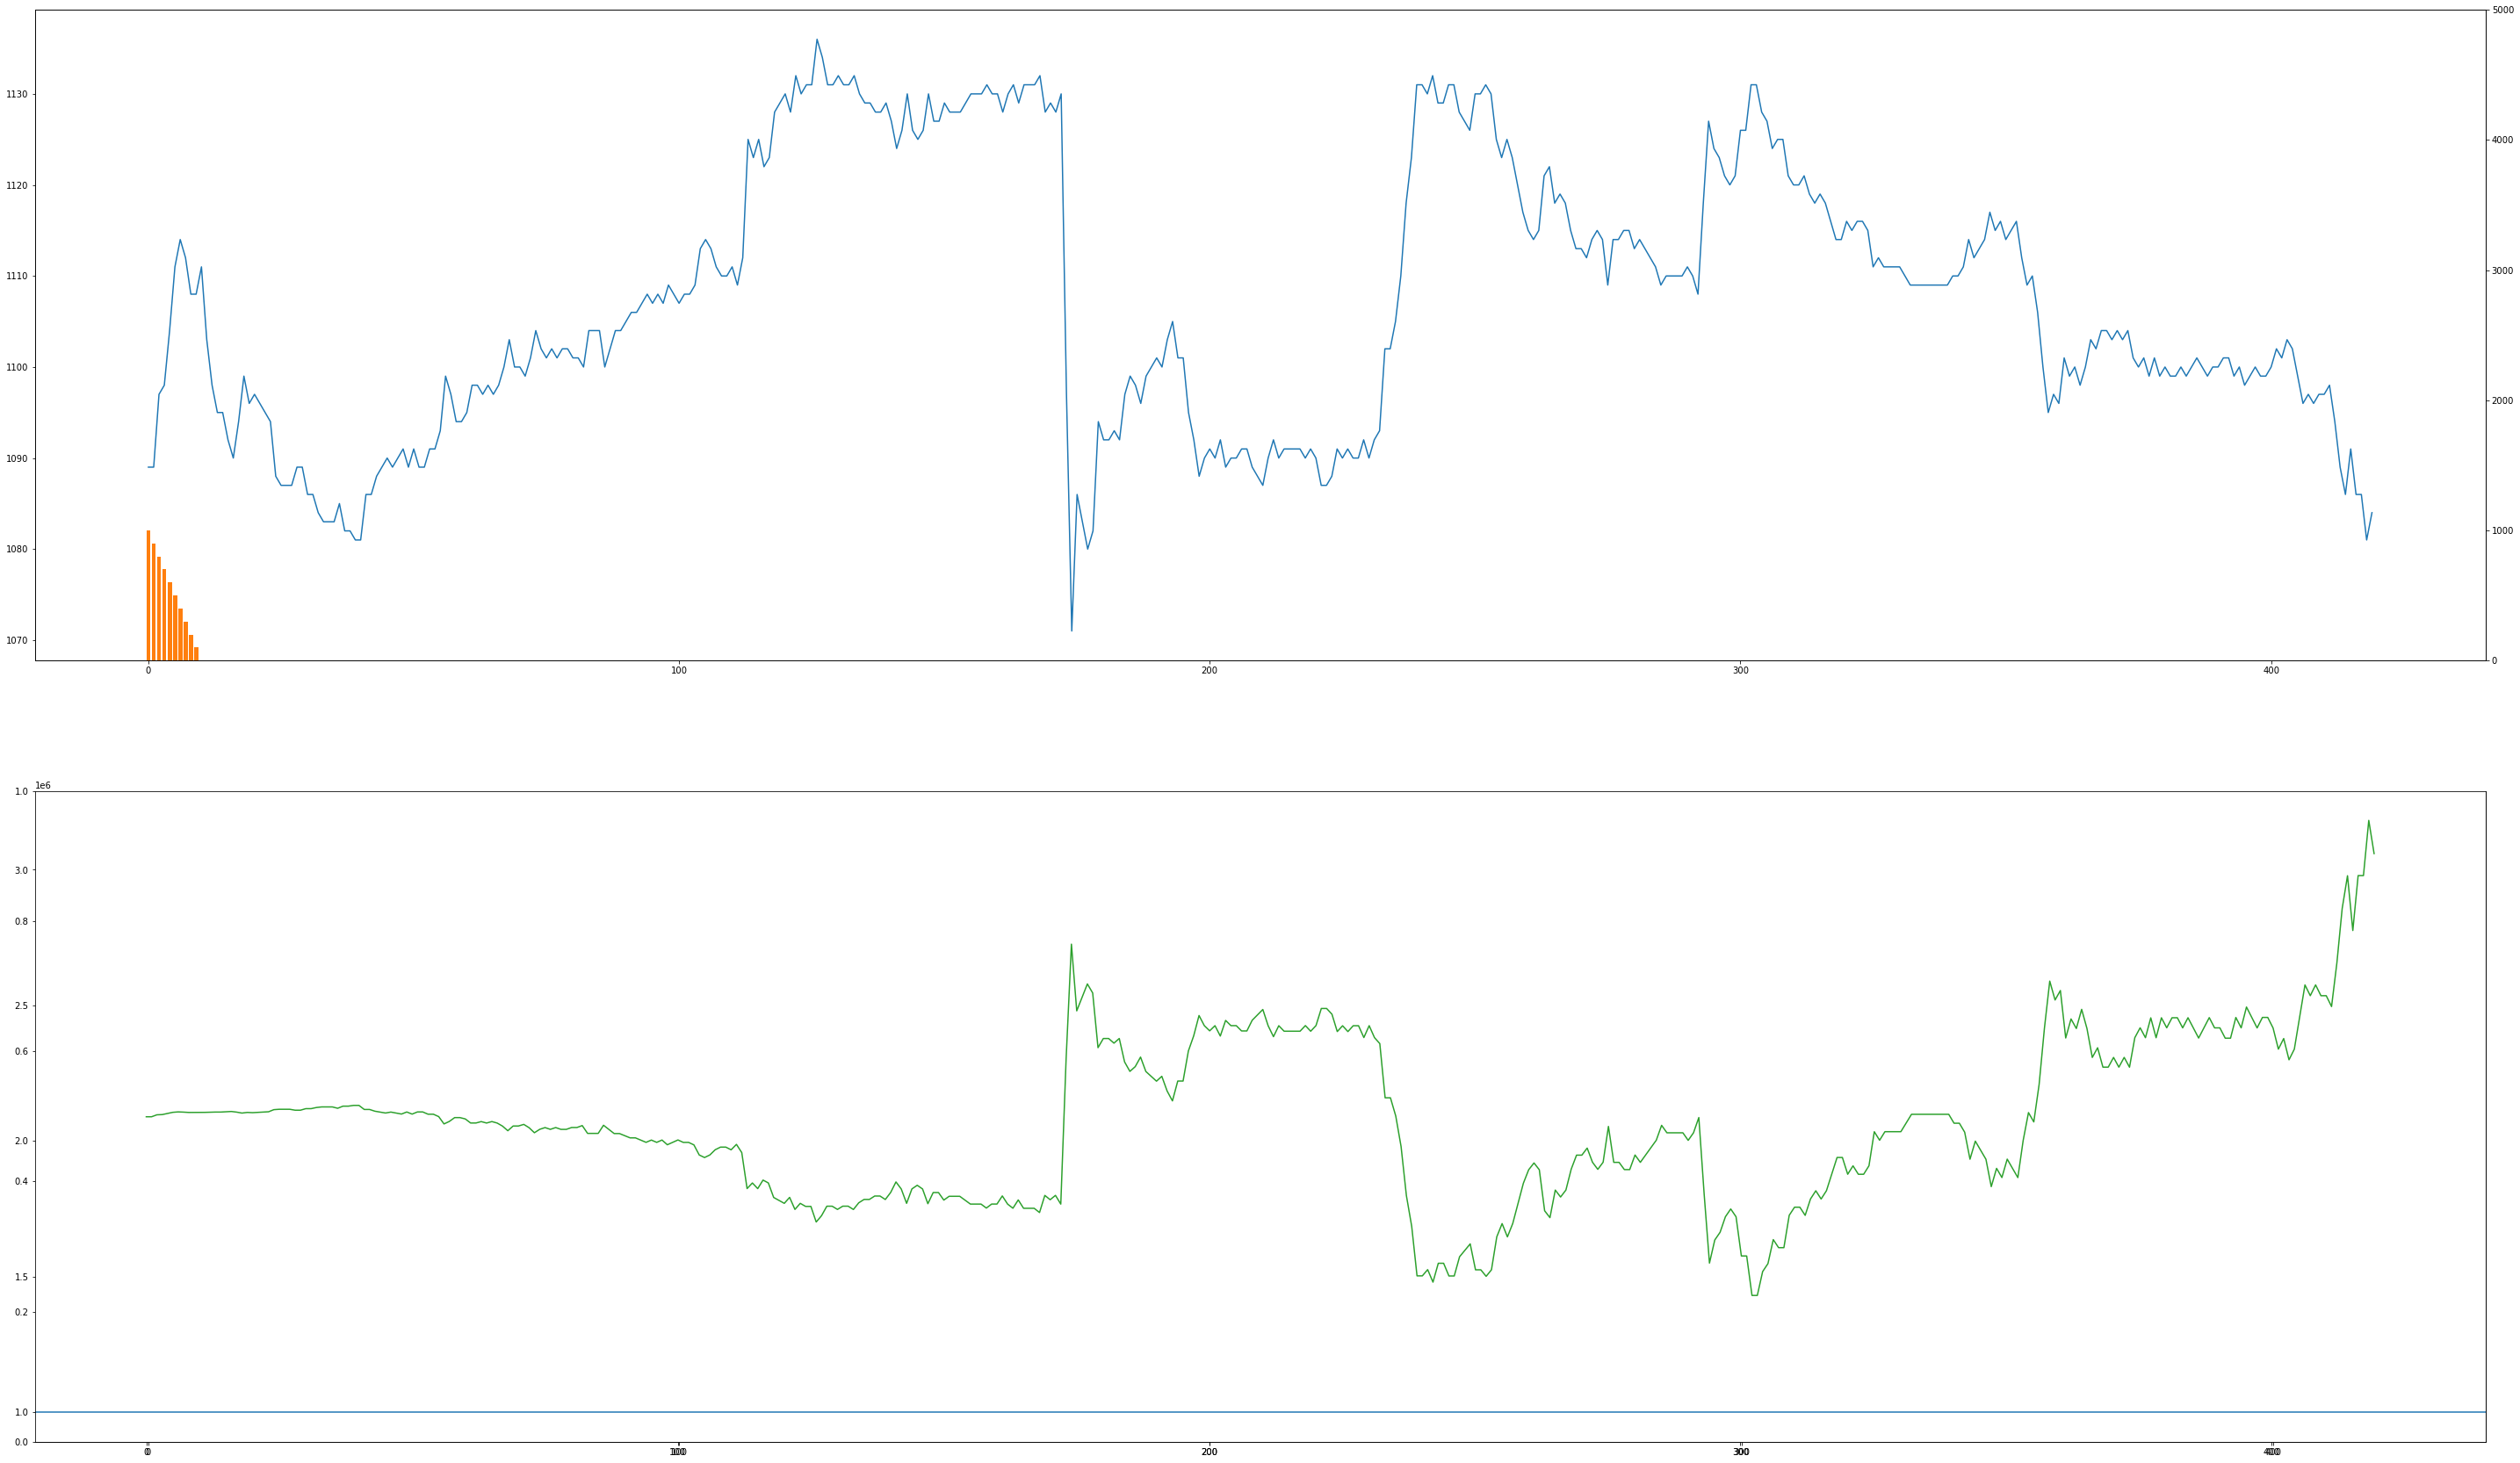

In [276]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(50,30))
ax1 = fig.add_subplot(211)

# 価格の描画
x = np.arange(0,len(datetime_array))
ax1.plot(x, price_array, zorder=1)

# 保有量の描画
ax2 = ax1.twinx()
ax2.bar(x, stocks_array, color="C1", zorder=2)
ax2.set_ylim(0, max(stocks_array)*5)

ax2 = fig.add_subplot(212, sharex=ax1)

# 全財産の推移
ax3 = fig.add_subplot(212)
ax3.plot(x, all_property_array, color="C2")
ax3.axhline(y=initial_cash, xmin=0, xmax=420)

### 環境のクローズ 

In [277]:
env.close()

### モデルの保存 

In [278]:
now_datetime = datetime.datetime.now()
now_str = now_datetime.strftime("%Y_%m_%d__%H_%M_%S")
agent.save(Path("agents")/Path(now_str))